In [1]:
import sys
sys.path.append("../src/")
import numpy as np
import pandas
import json
import ot
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import glob
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import random
import tqdm
from tqdm import tqdm
import seaborn as sb
import scipy as sp
import topo_util
from topo_util import noisy_disk, noisy_circle
import sklearn as sk
import sklearn.decomposition
import math
import pd

/home/syz/miniconda3/envs/tpot/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [27]:
np.random.seed(42)
data1 = noisy_circle(50, 0.25, 0, 0, 3 )
data2 = noisy_circle(50, 0.25, 8, 0, 5)
data3 = noisy_circle(50, 0.25, 18, -5, 4 )
data4 = noisy_disk(50, 0.1, -5.1, 0, 2 )
A = np.concatenate([data4, data1, data2, data3])
data1 = noisy_disk(50, 0.1, 0, 0, 2 )
data2 = noisy_circle(50, 0.25, 7, 0, 5 )
data3 = noisy_circle(50, 0.25, 17, 5, 3 )
data4 = noisy_circle(50, 0.25, -6, 0, 4 )
B = np.concatenate([data4, data1, data2, data3])

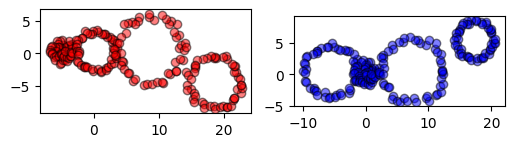

In [37]:
plt.figure(figsize = (6, 3))
plt.subplot(1, 2, 1)
plt.scatter(A[:,0],A[:,1], color = 'red', alpha = 0.5, edgecolor = 'k')
plt.gca().set_aspect('equal', adjustable='box')
plt.subplot(1, 2, 2)
plt.scatter(B[:,0],B[:,1], color = 'blue', alpha = 0.5, edgecolor = 'k')
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('../outputs/ex2_scatter.svg')
plt.show()

In [4]:
# C1 = sp.spatial.distance.cdist(A, A, "euclidean"); C1 /= np.mean(C1)
# C2 = sp.spatial.distance.cdist(B, B, "euclidean"); C2 /= np.mean(C2)
C_v0 = sp.spatial.distance.cdist(A, A, metric = "sqeuclidean"); C_v0 /= np.mean(C_v0)
C_v0 = np.exp(-C_v0)
C_v1 = sp.spatial.distance.cdist(B, B, metric = "sqeuclidean"); C_v1 /= np.mean(C_v1)
C_v1 = np.exp(-C_v1)

In [5]:
p = ot.unif(len(A))
q = ot.unif(len(B))
gw0, log0 = ot.gromov.gromov_wasserstein(
    C_v0, C_v1, p, q, 'square_loss', verbose=True, log=True)
print('Gromov-Wasserstein distances: ' + str(log0['gw_dist']))
P = gw0.T / gw0.sum(axis=0)[:, np.newaxis]
Id = [t[0] for t in A]
p = np.matmul(P, Id)

It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.229505e-01|0.000000e+00|0.000000e+00
    1|1.187940e-01|8.767819e-01|1.041565e-01
    2|4.996017e-02|1.377775e+00|6.883386e-02
    3|1.859801e-02|1.686319e+00|3.136217e-02
    4|8.625994e-03|1.156042e+00|9.972014e-03
    5|8.219728e-03|4.942566e-02|4.062655e-04
    6|7.330199e-03|1.213514e-01|8.895296e-04
    7|7.323724e-03|8.841466e-04|6.475245e-06
    8|7.323636e-03|1.199457e-05|8.784389e-08
    9|7.323636e-03|0.000000e+00|0.000000e+00
Gromov-Wasserstein distances: 0.007323635658020635


In [6]:
one = topo_util.get_eigvec(A[:50])
one = one - min(one)
one = (one/max(one))/4
two = topo_util.get_eigvec(A[50:2*50])
two = two - min(two)
two = 0.25 + (two/max(two))/4
three = topo_util.get_eigvec(A[2*50:3*50])
three = three - min(three)
three = 0.5 + (three/max(three))/4
four = topo_util.get_eigvec(A[3*50:4*50])
four = four - min(four)
four = 0.75 + (four/max(four))/4
color_figures = np.concatenate([one,two, three,four])

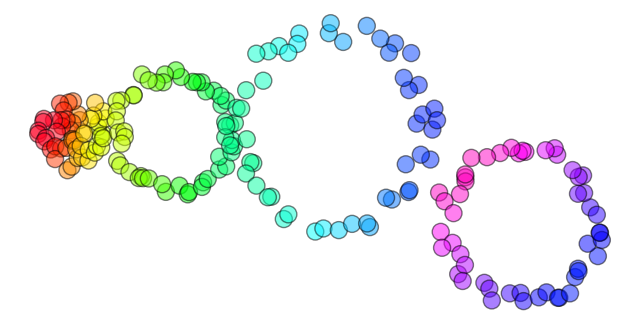

In [7]:
fig = plt.figure()
ax = fig.add_subplot()
scat = ax.scatter(A[:,0],A[:,1],c = color_figures, s=150,edgecolors='black', vmax=1, vmin=0, cmap = "gist_rainbow", alpha = 0.5)
plt.gca().set_aspect('equal')
ax.set_axis_off()
plt.savefig('../outputs/ex2_source.svg')
plt.show()

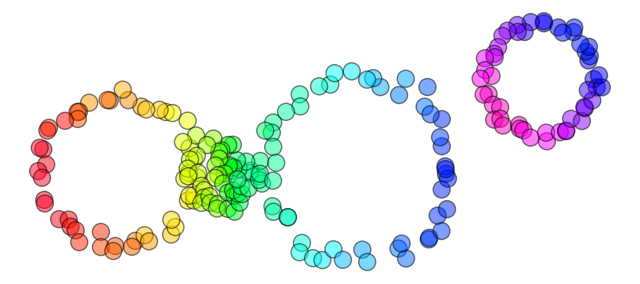

In [8]:
P_gromov = gw0.T / gw0.sum(axis=0)[:, np.newaxis]
p_gromov = np.matmul(P_gromov, color_figures)

fig = plt.figure()
ax = fig.add_subplot()
scat = ax.scatter(B[:,0],B[:,1],c = p_gromov, s=150,edgecolors='black', vmax=1, vmin=0, cmap = "gist_rainbow", alpha = 0.5)
plt.gca().set_aspect('equal')
ax.set_axis_off()
plt.savefig('../outputs/ex2_target_GW.svg')
plt.show()

In [9]:
# def PH(X):
#     df = pandas.DataFrame()
#     for ii in range(X.shape[1]):
#         df['x_{}'.format(ii)] =  X[:,ii]
#     df.to_csv("pointcloud.tsv", sep = '\t', index = False)
#     !julia ../src/PH.jl 
#     with open('PH.json','r') as f:
#         dic = json.load(f)
#     return dic    
# H_all = [PH(x) for x in tqdm([A,B])]
# df1 = topo_util.make_dataframe(H_all[0]["barcode"])
# df2 = topo_util.make_dataframe(H_all[1]["barcode"])
# 
# G_all = [hnx.Hypergraph({str(i) : k for (i, k) in enumerate(g['representatives'])}) for g in H_all]
# y0, w0, v0 = topo_util.process_hg(G_all[0], A.shape[0])
# y1, w1, v1 = topo_util.process_hg(G_all[1], B.shape[0])
# 
# # similarity with kernel
# h = 0.25
# K0 = topo_util.get_kernel(A, h)
# L0 = topo_util.symmetric_laplacian(K0)
# K0 /= K0.sum(-1).reshape(-1, 1)
# K1 = topo_util.get_kernel(B, h)
# L1 = topo_util.symmetric_laplacian(K1)
# K1 /= K1.sum(-1).reshape(-1, 1)
# y0_imputed = topo_util.impute_laplacian(y0, L0)
# y1_imputed = topo_util.impute_laplacian(y1, L1)
# y0 = y0_imputed; y1 = y1_imputed;

In [10]:
import topf
topf_all = [topf.topf(x, return_dict = True, complex_type = 'rips', fixed_num_features = [0, 10]) for x in tqdm([A, B])]
y0 = topf_all[0][0]
y1 = topf_all[1][0]
df1, df2 = [pandas.DataFrame({"b" : x[1]['birth_times'], "d" : x[1]['death_times'], "pers" : np.array(x[1]['death_times']) - np.array(x[1]['birth_times'])}) for x in topf_all]
p_spt, q_spt = df1.iloc[:, :2].values, df2.iloc[:, :2].values

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:28<00:00, 14.33s/it]


In [11]:
import ot
p_spt = df1.iloc[:, 0:2].to_numpy()
q_spt = df2.iloc[:, 0:2].to_numpy()
p, q = pd.augmented_weights(p_spt, q_spt)
C = pd.augmented_cost(p_spt, q_spt)

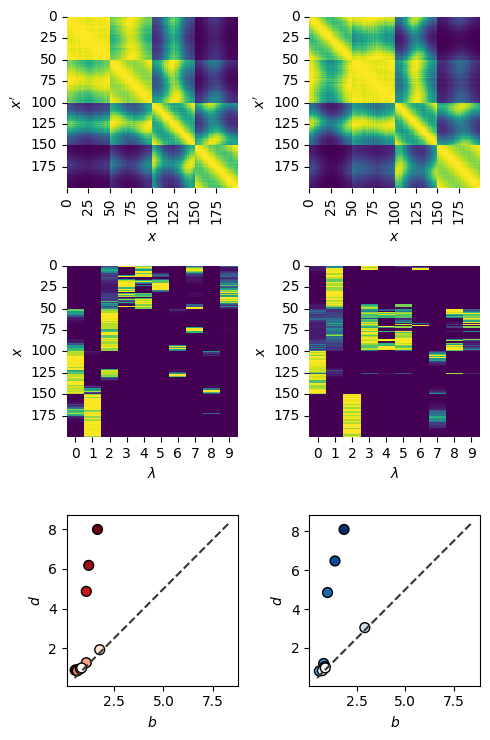

In [22]:
plt.figure(figsize = (5, 7.5))
plt.subplot(3, 2, 1)
sb.heatmap(C_v0, cmap = 'viridis', cbar = False, rasterized = True)
plt.yticks(ticks=np.arange(0, C_v0.shape[0], 25), labels=np.arange(0, C_v0.shape[0], 25))
plt.xticks(ticks=np.arange(0, C_v0.shape[0], 25), labels=np.arange(0, C_v0.shape[0], 25))
plt.xlabel("$x$"); plt.ylabel("$x'$")
plt.subplot(3, 2, 2)
sb.heatmap(C_v1, cmap= 'viridis', cbar = False, rasterized = True);
plt.yticks(ticks=np.arange(0, C_v0.shape[0], 25), labels=np.arange(0, C_v0.shape[0], 25))
plt.xticks(ticks=np.arange(0, C_v0.shape[0], 25), labels=np.arange(0, C_v0.shape[0], 25))
plt.xlabel("$x$"); plt.ylabel("$x'$")
plt.subplot(3, 2, 3)
sb.heatmap(y0, cmap = 'viridis', cbar = False, rasterized = True); plt.yticks(ticks=np.arange(0, C_v0.shape[0], 25), labels=np.arange(0, C_v0.shape[0], 25))
plt.ylabel("$x$"); plt.xlabel("$\\lambda$")
plt.subplot(3, 2, 4)
sb.heatmap(y1, cmap= 'viridis', cbar = False, rasterized = True); plt.yticks(ticks=np.arange(0, C_v0.shape[0], 25), labels=np.arange(0, C_v0.shape[0], 25))
plt.ylabel("$x$"); plt.xlabel("$\\lambda$")
plt.subplot(3, 2, 5)
pd.plot_pd(p_spt, color = np.arange(p_spt.shape[0]), cmap = "Reds_r")
plt.xlabel("$b$"); plt.ylabel("$d$")
plt.subplot(3, 2, 6)
pd.plot_pd(q_spt, color = np.arange(q_spt.shape[0]), cmap = "Blues_r")
plt.xlabel("$b$"); plt.ylabel("$d$")
plt.tight_layout()
plt.savefig("../outputs/ex2_heatmaps.svg")

In [13]:
import matplotlib.pyplot as plt
import importlib
import numpy as np
from tqdm import tqdm
import hypernetx as hnx
import tpot

/home/syz/miniconda3/envs/tpot/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [14]:
C_v0 = sp.spatial.distance.cdist(A, A, metric = "sqeuclidean"); C_v0 /= np.mean(C_v0)
C_v0 = np.exp(-C_v0)
C_v1 = sp.spatial.distance.cdist(B, B, metric = "sqeuclidean"); C_v1 /= np.mean(C_v1)
C_v1 = np.exp(-C_v1)
C_pd = pd.augmented_cost(p_spt, q_spt); C_pd /= C_pd[:-1, :-1].mean()

In [136]:
alpha = 0.5
beta = 1.0

w0 = ot.unif(y0.shape[0])
w1 = ot.unif(y1.shape[0])
v0 = p
v1 = q
pi_s, pi_f, _, = tpot.TPOT(y0, y1, w0, w1, v0, v1,
                           C_v0, C_v1, C_pd, 
                           alpha = alpha, beta = beta,  
                           print_iter = 25, iter = 100, numItermax = 1000, 
                           eps_s = 0.003, eps_f = 0.01,
                           solver = "sinkhorn", 
                          )

Iteration 0,	 obj = 0.0879510799796561,	 obj_terms = {'coot': 0.04958594238414955, 'ot': 0.0009787762075249792, 'gw': 0.037386361387981557}
Iteration 25,	 obj = 0.033277488839428,	 obj_terms = {'coot': 0.014740434179752434, 'ot': 0.008835194688192213, 'gw': 0.009701859971483352}
Iteration 50,	 obj = 0.03331123896862818,	 obj_terms = {'coot': 0.014609122275609692, 'ot': 0.008832872217723532, 'gw': 0.009869244475294952}
Iteration 75,	 obj = 0.03343960889090332,	 obj_terms = {'coot': 0.014883867203566837, 'ot': 0.008833241921736686, 'gw': 0.009722499765599794}


In [137]:
P = (pi_s / pi_s.sum(axis=-1)[:, np.newaxis])
Q = (pi_f[:-1, :-1] / pi_f[:-1, :-1].sum(axis=-1)[:, np.newaxis])
Q[np.isnan(Q)] = 0

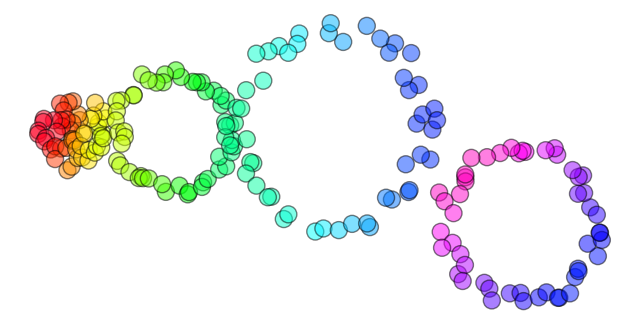

In [138]:
fig = plt.figure()
ax = fig.add_subplot()
scat = ax.scatter(A[:,0],A[:,1],c = color_figures, s=150,edgecolors='black', vmax=1, vmin=0, cmap = 'gist_rainbow', alpha = 0.5)
plt.gca().set_aspect('equal')
ax.set_axis_off()
plt.show()

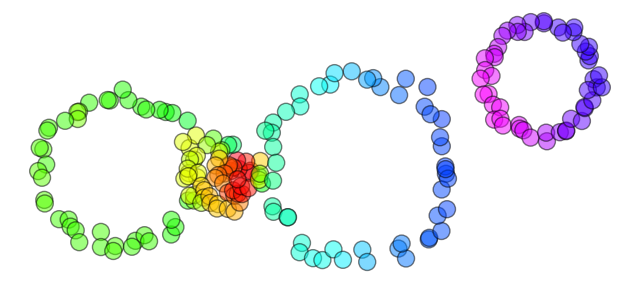

In [139]:
color_target  = np.matmul(P.T, color_figures)

fig = plt.figure()
ax = fig.add_subplot()
P_gromov = gw0.T / gw0.sum(axis=0)[:, np.newaxis]
p_gromov = np.matmul(P_gromov, color_figures)

plt.scatter(B[:,0],B[:,1],c = color_target,s=150,edgecolors='black', vmax=1, vmin=0, cmap = 'gist_rainbow', alpha = 0.5)
plt.gca().set_aspect('equal', adjustable='box')
ax.set_axis_off()

plt.savefig('../outputs/ex2_target_tpot_{}_beta_{}.svg'.format(alpha, beta))

plt.show()

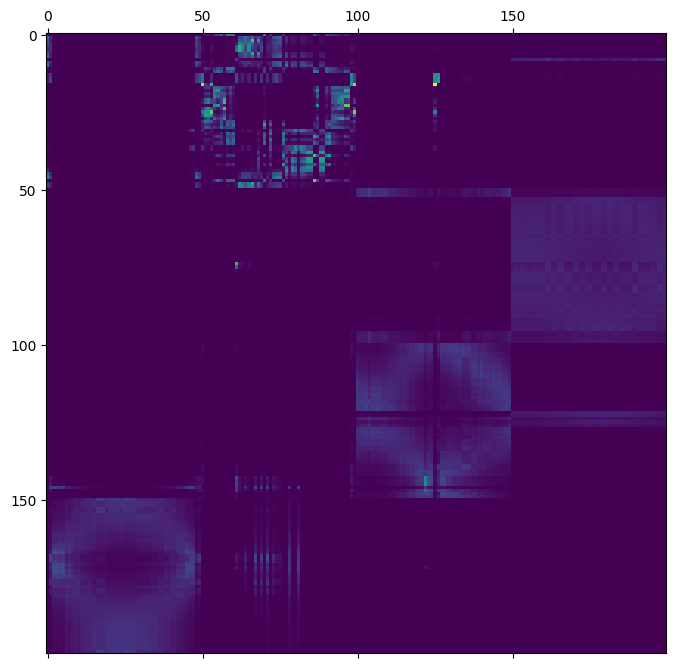

In [50]:
plt.matshow(P)

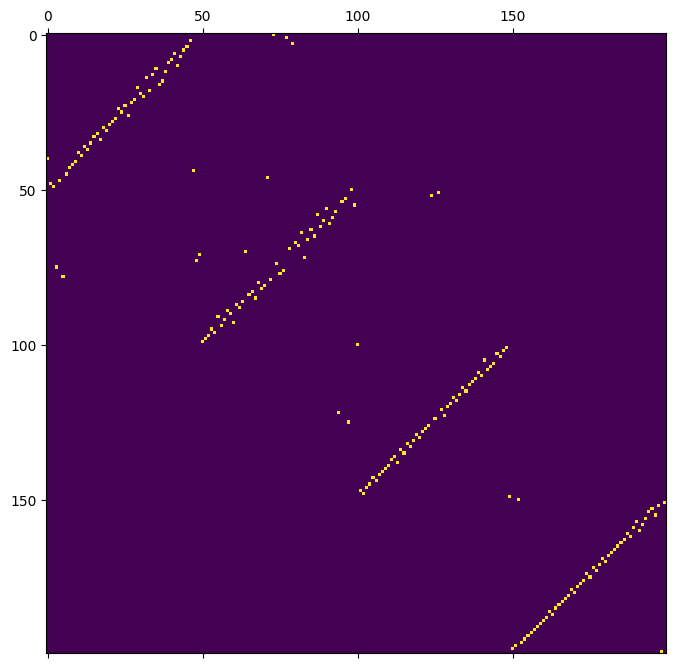

In [20]:
plt.matshow(P_gromov)

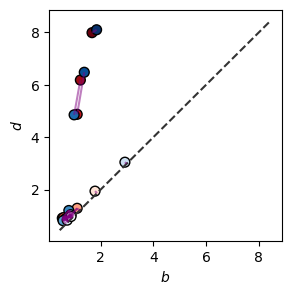

In [21]:
plt.figure(figsize = (3, 3))
pd.plot_pd(p_spt, color = np.arange(p_spt.shape[0]), cmap = "Reds_r", plot_diagonal = False)
pd.plot_pd(q_spt, color = np.arange(q_spt.shape[0]), cmap = "Blues_r")
pd.plot_pd_connections(p, q, p_spt, q_spt, pi_f)
plt.xlabel("$b$"); plt.ylabel("$d$")
plt.savefig('../outputs/pds_ex2.svg', dpi=300)